In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
# # 1. Parameters and Setup
# # You can later inject these parameters via Papermill if desired.
# dataset_path = "/Users/book_kuno/Desktop/ddos_datasets/2018.csv"  # Update path as needed
# sample_fraction = 0.05  # Use 1 for 100% of data (change to e.g., 0.05 for 5%)
# run_name = "rfc_run1-100percent"  # Change as desired
# year = "2018"
# model = "rfc"  # Change as desired
# # Define output folder and create it if needed
# output_folder = os.path.join("Outputs", year, model, run_name)
# os.makedirs(output_folder, exist_ok=True)
# print("Output folder created:", output_folder)

import os

# 1. Parameters and Setup
dataset_path = "/Users/book_kuno/Desktop/Final/ML_System/ddos_datasets/2018.csv"  # Update path as needed
sample_fraction = 0.0001 # Use 1 for 100% of data (change to e.g., 0.05 for 5%)
run_name = "rfc_run1-100percent"  # Change as desired
model = "rfc"  # Change as desired

# Extract the entire filename (without the extension) from the dataset_path.
filename = os.path.basename(dataset_path)  # e.g., "2018.csv"
csv_name = os.path.splitext(filename)[0]    # e.g., "2018" or "MyDataset" if the file is named that way

# Use csv_name as the dynamic folder name
output_folder = os.path.join("Outputs", csv_name, model, run_name)
os.makedirs(output_folder, exist_ok=True)
print("Output folder created:", output_folder)


Output folder created: Outputs/2018/rfc/rfc_run1-100percent


In [29]:
# Step 2: Load the Dataset
# Data Loading & Basic Information
data = pd.read_csv(dataset_path)
print("Original dataset shape:", data.shape)
print("First few rows:")
print(data.head())

# Drop any rows where 'label' is literally 'Label' (case-insensitive, just in case)
data = data[data['label'].str.lower() != 'label'].copy()

print("\nDataset info after cleanup:")
print(data.info())

print("\nClass distribution (after removing invalid 'Label'):")
print(data['label'].value_counts())

# Optional: Sample a fraction of the dataset (if desired)
data = data.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
print(f"Dataset shape after sampling {sample_fraction*100:.0f}%:", data.shape)

/var/folders/r9/g1ll_nxx2n70f0475ch9wkyr0000gn/T/ipykernel_94124/2323870812.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


Original dataset shape: (4339651, 26)
First few rows:
    timestamp  Dst Port protocol  Flow Duration  Flow Duration_rolling_mean  \
0  1518745716   55250.0      6.0       958807.0                   1815614.1   
1  1519099848     443.0      6.0      6081730.0                   2284039.7   
2  1519179901   52453.0      6.0         1428.0                      6703.5   
3  1518659728    3389.0      6.0      2169521.0                   9191415.4   
4  1519116456   49913.0      6.0           97.0                  24709922.5   

   Flow Duration_rolling_std  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
0               1.965582e+06           5.0           3.0            935.0   
1               2.888929e+06          10.0          12.0            646.0   
2               8.135168e+03           5.0           2.0            935.0   
3               2.752269e+07           8.0           7.0           1132.0   
4               4.818137e+07           3.0           1.0             31.0   

   TotLe

In [30]:
# Step 3: Preprocess the Data
data.columns = data.columns.str.strip()
data = data.dropna()
# Encode the target column ('Label')
encoder = LabelEncoder()
data['label'] = encoder.fit_transform(data['label'])
# Select only numeric columns for scaling
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('label')  # Exclude the target column
# Check for infinite or extremely large values
data[numeric_columns] = data[numeric_columns].replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset=numeric_columns)
# Scale the numeric feature columns
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
X = data[numeric_columns]
y = data['label']

In [31]:
# Step 4: Split the Dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [32]:
# Step 5: Initialize Random Forest (can add more parameters)
rf_model = RandomForestClassifier(
    n_estimators=100,            # Number of trees
    max_depth=10,                # Limit the depth of each tree
    min_samples_split=5,         # Minimum samples for a split
    min_samples_leaf=3,          # Minimum samples at a leaf
    max_features='sqrt',         # Use sqrt(n_features) features for splits
    bootstrap=True,              # Use bootstrap sampling
    class_weight='balanced',     # Handle class imbalance
    random_state=42              # Reproducibility
)


In [33]:
# Step 6: Train the Model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, min_samples_split=5,
                       random_state=42)

In [34]:
# Step 7: Validate the Model
y_val_pred = rf_model.predict(X_val)
# Retrieve class names from label encoder
attack_names = encoder.classes_
print("Validation Results")
print(classification_report(y_val, y_val_pred, target_names=attack_names))

Validation Results
                          precision    recall  f1-score   support

                  Benign       1.00      1.00      1.00    180788
        DDOS attack-HOIC       1.00      1.00      1.00     51361
    DDOS attack-LOIC-UDP       1.00      0.99      1.00       130
  DDoS attacks-LOIC-HTTP       1.00      1.00      1.00     43276
   DoS attacks-GoldenEye       1.00      1.00      1.00      3710
        DoS attacks-Hulk       1.00      1.00      1.00     34655
DoS attacks-SlowHTTPTest       1.00      1.00      1.00     10528
   DoS attacks-Slowloris       1.00      1.00      1.00      1026

                accuracy                           1.00    325474
               macro avg       1.00      1.00      1.00    325474
            weighted avg       1.00      1.00      1.00    325474



In [35]:
# # Step 8: Hyperparameter Tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],   # Number of trees
#     'max_depth': [10, 20, None],       # Tree depth (None means no limit)
#     'min_samples_split': [2, 5, 10],   # Minimum samples to split
#     'min_samples_leaf': [1, 3, 5],     # Minimum samples per leaf
#     'max_features': ['sqrt', 'log2'],  # Number of features considered
#     'bootstrap': [True, False]         # Bootstrap sampling
# }
 
# grid_search = GridSearchCV(
#     RandomForestClassifier(class_weight='balanced', random_state=42),  # Keep class balancing
#     param_grid,
#     cv=3,          # 3-fold cross-validation
#     scoring='accuracy',
#     n_jobs=-1,     # Use all available CPU cores
#     verbose=2
# )
 
# # Perform Hyperparameter Search
# grid_search.fit(X_train, y_train)
 
# # Retrieve Best Parameters and Retrain
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)
 
# rf_model_best = RandomForestClassifier(
#     **best_params, class_weight='balanced', random_state=42
# )
# rf_model_best.fit(X_train, y_train)
 

In [36]:
# Step 9: Test the Model
y_test_pred = rf_model.predict(X_test)

# Get attack names and exclude any mistakenly encoded labels like 'Label' or 'label'
attack_names = [name for name in encoder.classes_ if name.lower() != 'label']

# Sanity check: Ensure number of names matches unique labels in y_test
unique_labels = sorted(set(y_test))  # e.g., [0, 1, 2, 3]
filtered_attack_names = [attack_names[i] for i in unique_labels]

# Print results
print("Test Results")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=filtered_attack_names))

# Accuracy
acc = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {acc:.4f}")

Test Results
[[180877      0      0      0      8      0      0      0]
 [     0  51403      0      0      0      0      0      0]
 [     2      0    116      0      0      0      0      0]
 [     0      0      0  43319      0      0      0      0]
 [     0      0      0      0   3760      0      0      0]
 [     0      0      0      0      0  34612      0      0]
 [     0      0      0      0      0      0  10398      0]
 [     1      0      0      0      0      0      0    978]]
                          precision    recall  f1-score   support

                  Benign       1.00      1.00      1.00    180885
        DDOS attack-HOIC       1.00      1.00      1.00     51403
    DDOS attack-LOIC-UDP       1.00      0.98      0.99       118
  DDoS attacks-LOIC-HTTP       1.00      1.00      1.00     43319
   DoS attacks-GoldenEye       1.00      1.00      1.00      3760
        DoS attacks-Hulk       1.00      1.00      1.00     34612
DoS attacks-SlowHTTPTest       1.00      1.00      

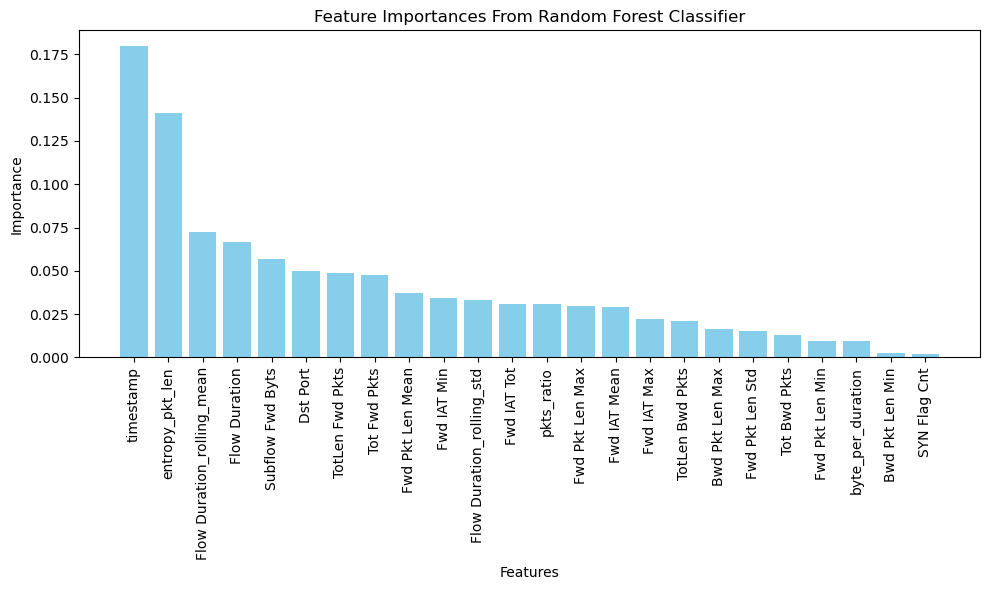

In [41]:
# Step 10: Compute and Visualize Feature Importance

# Check that the model supports feature importance (RandomForestClassifier does)
import numpy as np
import matplotlib.pyplot as plt

# Get the feature importances from the model
importances = rf_model.feature_importances_

# If X_test is a DataFrame, get its column names; otherwise, you must have a list of feature names
try:
    feature_names = X_test.columns
except AttributeError:
    # Replace with your list of feature names if X_test is not a DataFrame
    feature_names = [f"Feature {i}" for i in range(X_test.shape[1])]

# Sort features by importance in descending order
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances From Random Forest Classifier")
plt.bar(range(len(importances)), importances[indices], align='center', color='skyblue')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


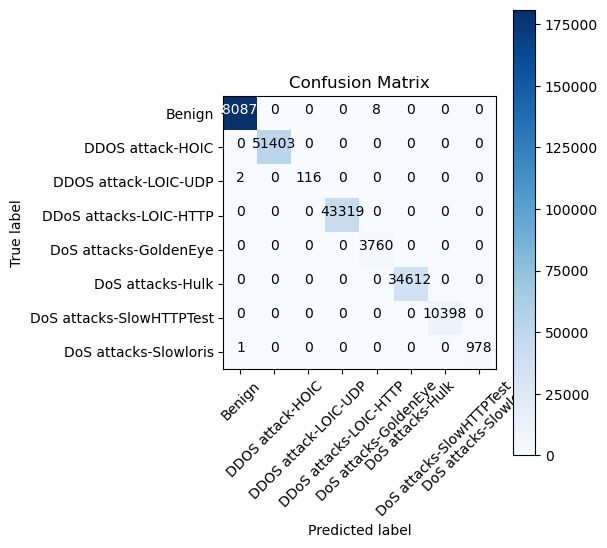

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

# Step 11: Confusion Matrix Visualization
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    # Create a new figure for the confusion matrix
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = "d"
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    return fig

# Assume y_test and y_test_pred are defined and contain the ground truth and predictions.
# Also assume that 'encoder' is your LabelEncoder used to encode labels.
cm = confusion_matrix(y_test, y_test_pred)
# Derive class names from your encoder
class_names = encoder.inverse_transform(np.unique(y_test))
fig_conmatrix = plot_confusion_matrix(cm, class_names, title="Confusion Matrix")


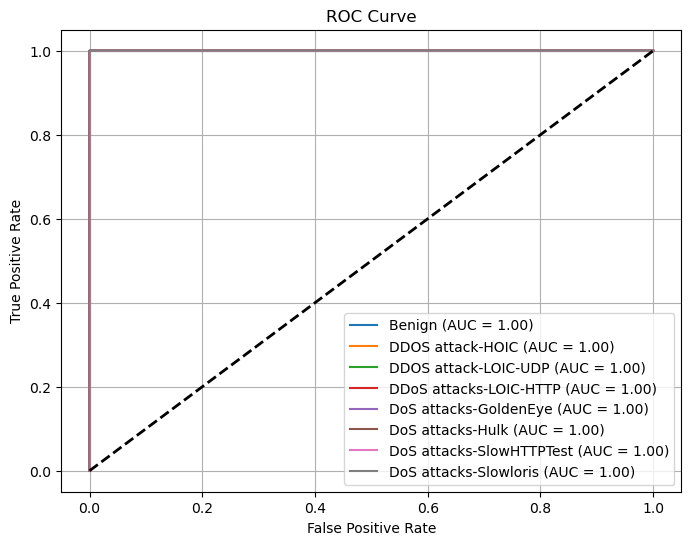

In [39]:
# Step 12: ROC Curve Visualization
fig_roc = plt.figure(figsize=(8, 6))

# Assume rf_model is your trained model and supports predict_proba
y_test_prob = rf_model.predict_proba(X_test)
n_classes = y_test_prob.shape[1]

# Try to get class names from your encoder based on y_test.
# If they don't match the number of classes from the model, generate default names.
try:
    class_names = encoder.inverse_transform(np.unique(y_test))
    if len(class_names) != n_classes:
        raise ValueError("Mismatch in number of classes.")
except Exception as e:
    print("Using default class names due to mismatch:", e)
    class_names = [f"Class {i}" for i in range(n_classes)]

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(np.array(y_test) == i, y_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.grid()


In [40]:
# Create a new output folder with a timestamp
# Define the folder name parameter (set this to whatever you like)

# Save the final model and scaler into the output folder
joblib.dump(rf_model, os.path.join(output_folder, 'rfc_final.pkl'))
joblib.dump(scaler, os.path.join(output_folder, 'scaler_final.pkl'))
print("Final model and scaler saved.")

# Save Test Classification Report as a text file
test_report = classification_report(y_test, y_test_pred)
with open(os.path.join(output_folder, "classification_report_test.txt"), "w") as f:
    f.write(test_report)
print("Test classification report saved.")

# Optionally, you can also save this plot to your output folder:
feature_importance_path = os.path.join(output_folder, "feature_importances.png")
plt.savefig(feature_importance_path, bbox_inches="tight")
print(f"Feature importance plot saved at: {feature_importance_path}")

# Save the confusion matrix plot
conf_matrix_path = os.path.join(output_folder, "confusion_matrix.png")
fig_conmatrix.savefig(conf_matrix_path, bbox_inches="tight")
print(f"Confusion matrix plot saved at: {conf_matrix_path}")

# Save the ROC curve plot
roc_curve_path = os.path.join(output_folder, "roc_curve.png")
fig_roc.savefig(roc_curve_path, bbox_inches="tight")
print(f"ROC curve plot saved at: {roc_curve_path}")

Final model and scaler saved.
Test classification report saved.
Feature importance plot saved at: Outputs/2018/rfc/rfc_run1-100percent/feature_importances.png
Confusion matrix plot saved at: Outputs/2018/rfc/rfc_run1-100percent/confusion_matrix.png
ROC curve plot saved at: Outputs/2018/rfc/rfc_run1-100percent/roc_curve.png


<Figure size 640x480 with 0 Axes>